In [229]:
import tensorflow as tf
import cv2 as cv, os
import numpy as np
from matplotlib import pyplot as plt

In [230]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# 1. Load Data

Use "image_dataset_from_directory" to load images conveniently, arranging them into batches of 32 images, and rescaling them for uniform processing

In [231]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 550 files belonging to 2 classes.


Create numpy iterator to better access data

In [232]:
data_iterator = data.as_numpy_iterator()

In [233]:
batch = data_iterator.next()

Batch consists of the images, and then labels (thus length should be =2)

In [234]:
len(batch)

2

Images represented as numpy arrays

In [235]:
batch[0].shape

(32, 256, 256, 3)

In [236]:
# 0 = no train, 1 = train
batch[1]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Plot sample images and see what class they belong to

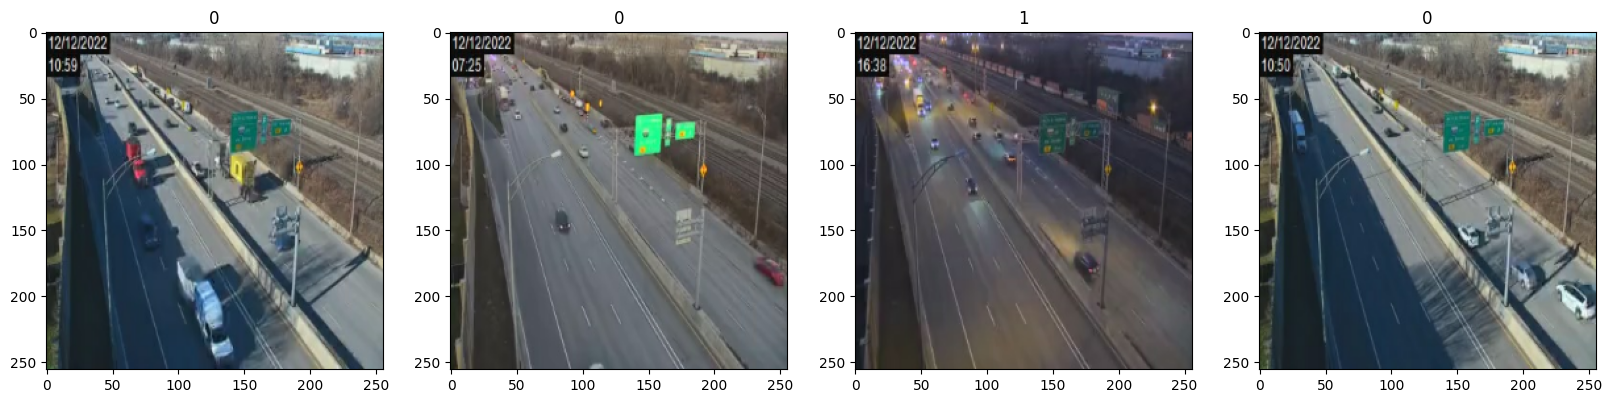

In [237]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Pre-process data
Scale data (0-1 instead of 0-255)

Scale data in pipeline.
x = represents images
y = target (labels), no transformation
Documentation in https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map

In [238]:
scaled_data = data.map(lambda x, y: (x/255, y))

In [239]:
# access iterator and show next batch
scaled_iterator = scaled_data.as_numpy_iterator()

## Split data

In [240]:
#show number of batches (of 32 images each)
len(scaled_data)

18

In [243]:
train_size = int(len(scaled_data)*.7)
val_size = int(len(scaled_data)*.2)+1
test_size = int(len(scaled_data)*.1)+1

In [244]:
train_size + val_size + test_size

18

In [245]:
#establish partitions
train = scaled_data.take(train_size)
val = scaled_data.skip(train_size).take(val_size)
test = scaled_data.skip(train_size+val_size).take(test_size)

# Build Deep Learning Model

In [246]:
#Sequential is good when we habe one input and one output; the layers below are used to build the neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [247]:
#instatiate model
model = Sequential()

## Adding layers to the model

In [248]:
# sequential adding layers, "architectural decisions..."
# add a convolutional layer (input layer), with 16 filters (to condense image), 3 by 3 pixels in size, stride of 1 (move by 1 px), 'relu' is the activation, suppressing negative values, in
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# MapPooling is reducing data be taking maximas
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# Reduce channel values
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))
# Reduce to one single output = 0 or 1 = train or no train
model.add(Dense(1, activation='sigmoid'))

In [249]:
# adam = name of optimizer
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [250]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 30, 30, 16)      

# Train the model

In [251]:
logdir = 'logs'

In [252]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs = 20, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/20
12/12 [==============================] - 25s 2s/step - loss: 0.5713 - accuracy: 0.7396 - val_loss: 0.4281 - val_accuracy: 0.8594
Epoch 2/20
 4/12 [=========>....................] - ETA: 12s - loss: 0.4535 - accuracy: 0.8438

## Plot Performance

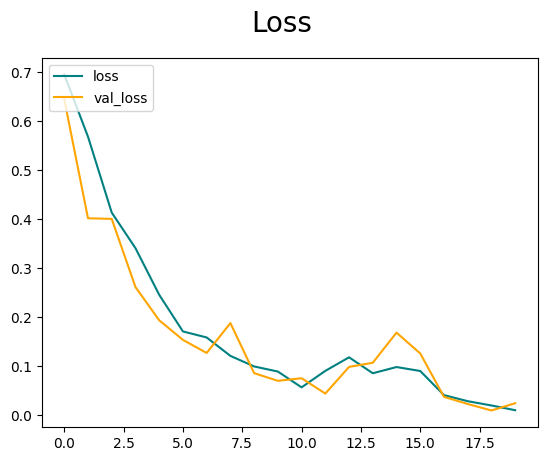

In [222]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

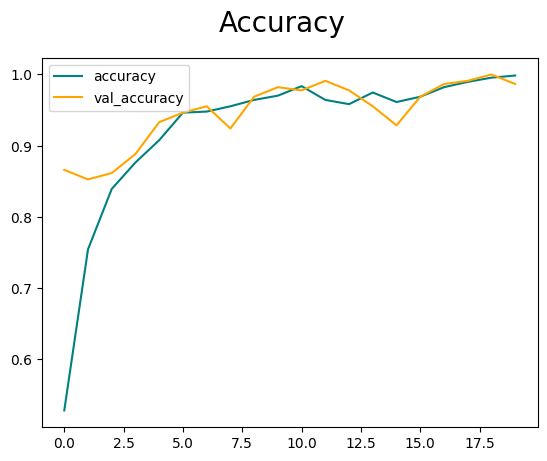

In [223]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluate Performance

In [224]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [225]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [226]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 179ms/step


In [227]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy: 1.0


# Test

## Single Image

In [326]:
import cv2

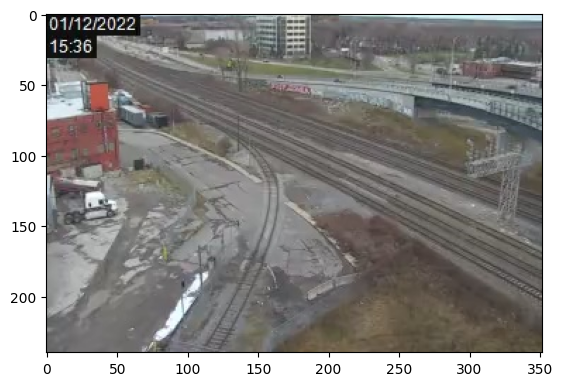

In [333]:
img = cv2.imread('test\\3899_1669927080_0.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

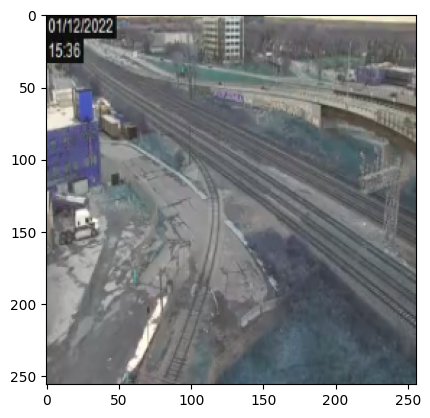

In [334]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [335]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 48ms/step


In [336]:
yhat

array([[0.00024622]], dtype=float32)

In [337]:
if yhat > 0.5:
    print(f'This is a train.')
else:
    print(f'There is no train.')

There is no train.


## Loading a whole folder of images and predict

In [371]:
# The input to model.predict() function in this case needs to be given as a numpy array of shape (N, 224, 224, 3) where N is number of input images.

# To achieve this, we can stack the N individual numpy arrays of size ( 1, 224, 224, 3) into one array of size ( N, 224, 224, 3) and then pass it to model.predict() function.
#from tf.keras import utils

trainImgList = []
folder_path = 'test'

for imgFile in os.listdir(folder_path):
    try:
        img = os.path.join(folder_path, imgFile)
        img = tf.keras.utils.load_img(img, target_size=(255, 255))
        img = tf.keras.utils.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        trainImgList.append(img)
    except:
        pass

In [372]:
len(trainImgList)

13

In [373]:
trainPreds = model.predict(np.vstack(trainImgList))

1/1 [==============================] - 0s 197ms/step


In [374]:
trainPreds

array([[0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.]], dtype=float32)

# Process and sort inbox folder

In [7]:
import shutil

In [58]:
inbox_path = 'inbox'
outbox_path = 'outbox'
train_dir = os.path.join(outbox_path, 'train')
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
    
no_train_dir = os.path.join(outbox_path, 'no_train')
if not os.path.exists(no_train_dir):
    os.makedirs(no_train_dir)

for imgFile in os.listdir(inbox_path):
    try:
        # open image and pre-process for use with model
        img_path = os.path.join(inbox_path, imgFile)
        img = tf.keras.utils.load_img(img_path, target_size=(256, 256)) #why was one model trained with size = 255?
        img = tf.keras.utils.img_to_array(img)
        img = np.expand_dims(img, axis=0)
    except:
        print("could not open " + imgFile)
        pass

    try:
        # use model to predict if this image contains a train
        yhat = model.predict(img)
        if yhat > 0.5:
            print(img_path + ' shows a train.')
            shutil.move(img_path, train_dir)
        else:
            shutil.move(img_path, no_train_dir)
    except:
        print(f'something went wrong processing {img_path}')
        pass

1/1 [==============================] - 0s 45ms/step
inbox\3378_2022-12-07_17h28_59_0.jpg shows a train.
1/1 [==============================] - 0s 41ms/step
inbox\3378_2022-12-07_17h28_59_45.jpg shows a train.
1/1 [==============================] - 0s 38ms/step
inbox\3378_2022-12-07_17h29_59_0.jpg shows a train.
1/1 [==============================] - 0s 51ms/step
inbox\3378_2022-12-07_17h29_59_45.jpg shows a train.
1/1 [==============================] - 0s 47ms/step
inbox\3378_2022-12-07_17h34_59_0.jpg shows a train.
1/1 [==============================] - 0s 64ms/step
inbox\3378_2022-12-07_17h34_59_45.jpg shows a train.
1/1 [==============================] - 0s 61ms/step
inbox\3378_2022-12-07_17h36_00_0.jpg shows a train.
1/1 [==============================] - 0s 48ms/step
inbox\3378_2022-12-07_17h36_00_45.jpg shows a train.
1/1 [==============================] - 0s 45ms/step
inbox\3378_2022-12-07_17h38_59_0.jpg shows a train.
1/1 [==============================] - 0s 67ms/step
inbox\33

# Saving the model

In [228]:
model.save(os.path.join('models', 'cam3899_model_v3.h5'))

# Load a model and use it

In [4]:
from tensorflow.keras.models import load_model

In [5]:
model_3378 = load_model(os.path.join('models','cam3378_model_v4.h5'))

In [391]:
model_3899 = load_model(os.path.join('models','cam3899_model_v1.h5'))

In [395]:
model_3319 = load_model(os.path.join('models','cam3319_model_v1.h5'))

In [6]:
model = model_3899

# Motion Detection

The following code is built using the examples from https://www.kdnuggets.com/2022/08/perform-motion-detection-python.html

## Libraries

In [2]:
# Importing the OpenCV libraries  
import cv2  

# import od for path handling
import os

# imutils used for resizing
import imutils

# math for point distance calculation
import math

## Main Capturing Process

In [179]:
# Read video from file
full_video_file_name = os.path.join('C:\\Users\\georg\\Pictures\\TrainDetector\\results\\media\\train\\3378\\2023-04-21', '3378_2023-04-21_19h40_01.mp4')
video = cv2.VideoCapture(full_video_file_name)

# initialize the first frame in the video stream
firstFrame = None

In [221]:
# grab current frame
check, curFrame = video.read()

In [222]:
# convert it to grayscale, and blur it to remove noise (radius 21 px)
curFrame = imutils.resize(curFrame, width=350) # not really necessary, but keep line when processing higher resolution
grayImage = cv2.cvtColor(curFrame, cv2.COLOR_BGR2GRAY)
grayImage = cv2.GaussianBlur(grayImage, (21, 21), 0)

In [223]:
# if the first frame is None, initialize it
if firstFrame is None:
    firstFrame = grayImage

In [224]:
# compute the absolute difference between the current frame and
# first frame
frameDelta = cv2.absdiff(firstFrame, grayImage)
thresh = cv2.threshold(frameDelta, 25, 255, cv2.THRESH_BINARY)[1]

In [225]:
# dilate the thresholded image to fill in holes, then find contours
# on thresholded image
thresh = cv2.dilate(thresh, None, iterations=2)
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [226]:
# loop over the contours
for c in cnts:
    # if the contour is too small, ignore it
    if cv2.contourArea(c) < min_area:
        continue
    # compute the bounding box for the contour, draw it on the frame,
    # and update the text
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(curFrame, (x, y), (x + w, y + h), (0, 255, 0), 2)

In [227]:
# write one frame to a file
frame_file = os.path.join('C:\\Users\\georg\\Pictures\\TrainDetector\\results\\media\\train\\3378\\2023-04-21', 'test.jpg')
cv2.imwrite(frame_file, curFrame)

True

In [46]:
# initialization
cam_num = 3378
date = '2023-04-12'

# image path
image_path = f'C:\\Users\\georg\\Pictures\\TrainDetector\\results\\media\\train\\{cam_num}\\{date}'
mask_path = 'C:\\Users\\georg\\Pictures\\TrainDetector\\models\\masks\\'

# image width
image_width = 350

# Read video from file
full_video_file_name = os.path.join(image_path, '3378_2023-04-12_16h36_00.mp4')
video = cv2.VideoCapture(full_video_file_name)
print(full_video_file_name)

# Read the mask
full_mask_file_name = os.path.join(mask_path, f'{cam_num}_mask.png')
mask = imutils.resize(cv2.imread(full_mask_file_name, 0), width = image_width)

# initialize the first frame in the video stream
firstFrame = None

# Initialize frame counter
frameNo = 0

# minimum size of motion detection
min_area = 170

# blur radius
blur_radius = 21

# maximum distance for object tracking
max_dist = 15

# minimum motion needed
min_motion = 4

# store centers of detected motion from previous frame
pfCenters = []

# list of tracked objects / areas
trackedObjects = {}
trackedObjectHistory = []
trackId = 0

# Debug?
debug = False

C:\Users\georg\Pictures\TrainDetector\results\media\train\3378\2023-04-12\3378_2023-04-12_16h36_00.mp4


In [47]:
# loop code
while True:

    # grab current frame
    check, curFrame = video.read()
    
    # when no frame can be grabbed, we reached the end of the file
    if curFrame is None:
        break
        
    # Current frame's center points
    cfCenters = []

    # resize for uniformity
    curFrame = imutils.resize(curFrame, width = image_width) # not really necessary, but keep line when processing higher resolution
    
    # apply mask
    maskedImage = cv2.bitwise_and(curFrame, curFrame, mask = mask)
    
    # convert it to grayscale, and blur it to remove noise (radius 21 px)
    grayImage = cv2.cvtColor(maskedImage, cv2.COLOR_BGR2GRAY)
    grayImage = cv2.GaussianBlur(grayImage, (blur_radius, blur_radius), 0)

    # if the first frame is None, initialize it
    if firstFrame is None:
        firstFrame = grayImage

    # compute the absolute difference between the current frame and
    # first frame
    frameDelta = cv2.absdiff(firstFrame, grayImage)
    thresh = cv2.threshold(frameDelta, 25, 255, cv2.THRESH_BINARY)[1]

    # dilate the thresholded image to fill in holes, then find contours
    # on thresholded image
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # loop over the contours
    for c in cnts:
        # if the contour is too small, ignore it
        if cv2.contourArea(c) < min_area:
            continue
        # compute the bounding box for the contour, draw it on the frame,
        # and update the text
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(curFrame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # print box details
        #print(f'Frame {frameNo} - BOX {x}, {y} dimension {w}, {h}')
        
        # calculate box centers and draw circle
        cx = int(x + w / 2)
        cy = int(y + h / 2)
        cfCenters.append((cx, cy)) 
    
    
    # track EXISTING objects in current frame
    for objectId, pt2 in trackedObjects.copy().items():
        objectExists = False

        # go through object positions in current frame
        for pt in cfCenters.copy():
            # calculate distance between the two points (of current and previous frame)
            distance = math.hypot(pt2[0] - pt[0], pt2[1] - pt[1])

            # if distance is below threshold, consider it's the same object, and *update* position
            if distance < max_dist:
                objectExists = True
                trackedObjects[objectId] = pt
                # remove from list when tracked, so we can later compare with last frame to find new objects
                cfCenters.remove(pt)
                continue

        # remove object from tracking if not existing any more        
        if not objectExists:
            trackedObjects.pop(objectId)
            #pass

    # find NEW objects by measure distance of remaining objects between current frame to previous frame
    for pt in cfCenters:
        for pt2 in pfCenters:
            # calculate distance between the two points (of current and previous frame)
            distance = math.hypot(pt2[0] - pt[0], pt2[1] - pt[1])

            # if distance is below threshold, consider it's the same object
            if distance < max_dist:
                trackedObjects[trackId] = pt
                trackId += 1
                
    # draw circle ID number on frame
    for objectId, pt in trackedObjects.items():
        cv2.circle(curFrame, pt, 5, (0, 0, 255), -1)
        cv2.putText(curFrame, str(objectId), (pt[0], pt[1] - 7), 0, 1, (0, 0, 255))
    
    # print current, last frame, and tracked objects
    if debug:
        print(pfCenters)
        print(cfCenters)
        print(trackedObjects)
    
    # store tracked object history
    trackedObjectHistory.append(trackedObjects.copy())
    
    # write current frame image
    frame_file = os.path.join(image_path, f'test{frameNo}.jpg')
    cv2.imwrite(frame_file, curFrame)
    
    # write the delta frame
    frame_file = os.path.join(image_path, f'test{frameNo}d.jpg')
    #cv2.imwrite(frame_file, thresh)
    
    # write grey, masked frame
    frame_file = os.path.join(image_path, f'test{frameNo}m.jpg')
    #cv2.imwrite(frame_file, grayImage)
    
    # count frames
    frameNo += 1
    
    # copy center points of current frame
    pfCenters = cfCenters.copy()
    
# free any used memory
video.release()
cv2.destroyAllWindows()

In [48]:
# collect each object's start and end point 
trackedObjects = {}

for objectList in trackedObjectHistory:
    # check each item in object history
    for objectId, pt in objectList.items():
        
        # check if object is already tracked, then only update second coordinates:
        if objectId in trackedObjects.keys():
            trackedObjects[objectId] = (trackedObjects[objectId][0], pt)
            #print(f'{objectId} already exists in list')
        
        # if new, add to list
        else:
            trackedObjects[objectId] = (pt, pt)
            if debug:
                print(f'added object id {objectId} to list')

In [49]:
# calculate each objects absolute movement
for key, currentObject in trackedObjects.items():
    dx = currentObject[1][0] - currentObject[0][0]
    dy = currentObject[1][1] - currentObject[0][1]
    trackedObjects[key] = (currentObject[0], currentObject[1], (dx, dy))

In [50]:
# calculate total x and y movement of all objects combined
X = 0
Y = 0

for currentObject in trackedObjects.values():
    X += currentObject[2][0]
    Y += currentObject[2][1]

In [51]:
print(X, Y)

-91 163


In [52]:
if X > min_motion:
    print('Objects were mostly moving RIGHT')
elif X < -min_motion:
    print('Objects were mostly moving LEFT')
else:
    print('NO MOTION was detected')

Objects were mostly moving LEFT


In [53]:
video.release()
cv2.destroyAllWindows()

In [54]:
trackedObjects

{0: ((35, 170), (31, 173), (-4, 3)),
 1: ((42, 210), (37, 215), (-5, 5)),
 2: ((66, 194), (66, 194), (0, 0)),
 3: ((89, 176), (88, 176), (-1, 0)),
 4: ((40, 198), (32, 198), (-8, 0)),
 5: ((121, 103), (66, 144), (-55, 41)),
 6: ((15, 228), (15, 228), (0, 0)),
 7: ((115, 140), (113, 144), (-2, 4)),
 8: ((172, 70), (139, 110), (-33, 40)),
 9: ((84, 181), (83, 181), (-1, 0)),
 10: ((108, 149), (103, 153), (-5, 4)),
 11: ((57, 209), (52, 224), (-5, 15)),
 12: ((22, 222), (16, 227), (-6, 5)),
 13: ((33, 182), (35, 183), (2, 1)),
 14: ((91, 168), (90, 168), (-1, 0)),
 15: ((30, 221), (32, 221), (2, 0)),
 16: ((81, 183), (78, 184), (-3, 1)),
 17: ((96, 151), (90, 157), (-6, 6)),
 18: ((36, 196), (38, 198), (2, 2)),
 19: ((89, 177), (88, 178), (-1, 1)),
 20: ((115, 146), (108, 155), (-7, 9)),
 21: ((129, 125), (125, 131), (-4, 6)),
 22: ((136, 104), (147, 116), (11, 12)),
 23: ((87, 177), (95, 169), (8, -8)),
 24: ((55, 86), (138, 65), (83, -21)),
 25: ((36, 198), (36, 198), (0, 0)),
 26: ((77

In [551]:
import pandas as pd

In [624]:
root_folder = 'C:\\Users\\georg\\Pictures\\TrainDetector'

In [625]:
configuration_file = 'train_detection_configuration.csv'

In [626]:
configuration = pd.read_csv(os.path.join(root_folder, configuration_file), encoding = "ISO-8859-1")

In [627]:
configuration

,cam_id,cam_description,fb_posting,nr_enable,nr_version,motion_enable,mask,right_orientation,left_orientation
0,3319,"CN Kingston, Aut. 20 at rue Morgan (Beaconsfield)",x,x,6.0,x,x,East,West
1,3326,"CN Rouses Point, Aut. 10 at boul. Leduc",NaN,NaN,NaN,x,x,South,North
2,3362,"CP Adirondack, Aut. 20, west of Saint-Pierre i...",NaN,x,2.0,x,x,North,South
3,3365,"CN Montreal, Aut 20 at 24th",x,x,2.0,x,x,East,West
4,3367,"CN Montreal, Aut. 20 at 55e Avenue (Dorval)",NaN,x,4.0,x,x,East,West
5,3371,"CN Kingston, Aut. 20 at av. Oakville (Gare Pin...",NaN,x,3.0,x,x,East,West
6,3373,"CN Kingston, Aut. 20 (Sainte-Anne-de-Bellevue ...",NaN,x,2.0,x,x,East,West
7,3375,"CN Kingston, Aut. 20 at Dorion",NaN,NaN,NaN,NaN,NaN,East,West
8,3378,"CN St-Hyacinthe, Route 112 (east) at pont Vict...",x,x,8.0,x,x,East,West
9,3399,"CP Vaudreuil, Aut. 13 at aut. 20 (Lachine)",x,x,3.0,x,x,East,West


In [630]:
configuration.loc[(configuration['cam_id'] == 3814)].iloc[0]['nr_version']

AttributeError: 'numpy.float64' object has no attribute 'isnan'

In [634]:
configuration['cam_id']

0     3319
1     3326
2     3362
3     3365
4     3367
5     3371
6     3373
7     3375
8     3378
9     3399
10    3814
11    3830
12    3899
13    3351
14    3379
15    3380
Name: cam_id, dtype: int64

In [636]:
cam_list = []
for cam_id in configuration['cam_id']:
    cam_list.append(cam_id)

In [641]:
len(cam_list)

16

# Checksum calculation

In [77]:
import os, requests, hashlib

In [56]:
cam_URL = f'https://ville.montreal.qc.ca/Circulation-Cameras/GEN211.jpeg'

In [57]:
cam_URL

'https://ville.montreal.qc.ca/Circulation-Cameras/GEN211.jpeg'

In [97]:
i = 4
data_file_name = os.path.join('inbox', f'test{i}.jpeg')

In [98]:
data_file = open(data_file_name, 'wb')

In [99]:
response = requests.get(cam_URL, stream=True)

In [100]:
for block in response.iter_content(1024):
    if not block:
        break
    data_file.write(block)

In [101]:
data_file.close()

In [102]:
hashlib.md5(open(data_file_name, 'rb').read()).hexdigest()

'5dadea4c9c969fcc1a17ced856c5fe8a'

# Logging

In [103]:
import logging

In [104]:
log = logging.getLogger('TrainDetectorLog')

In [105]:
log.info('Hey!')

In [106]:
log??

Type:           Logger
String form:    <Logger TrainDetectorLog (WARNING)>
File:           c:\users\georg\appdata\local\programs\python\python310\lib\logging\__init__.py
Source:        
class Logger(Filterer):
    """
    Instances of the Logger class represent a single logging channel. A
    "logging channel" indicates an area of an application. Exactly how an
    "area" is defined is up to the application developer. Since an
    application can have any number of areas, logging channels are identified
    by a unique string. Application areas can be nested (e.g. an area
    of "input processing" might include sub-areas "read CSV files", "read
    XLS files" and "read Gnumeric files"). To cater for this natural nesting,
    channel names are organized into a namespace hierarchy where levels are
    separated by periods, much like the Java or Python package namespace. So
    in the instance given above, channel names might be "input" for the upper
    level, and "input.csv", "input.xls

In [107]:
__name__

'__main__'

In [108]:
import os

In [111]:
level = os.environ.get('LOGLEVEL')

In [112]:
level

In [113]:
logging.Formatter??

Init signature:
logging.Formatter(
    fmt=None,
    datefmt=None,
    style='%',
    validate=True,
    *,
    defaults=None,
)
Source:        
class Formatter(object):
    """
    Formatter instances are used to convert a LogRecord to text.

    Formatters need to know how a LogRecord is constructed. They are
    responsible for converting a LogRecord to (usually) a string which can
    be interpreted by either a human or an external system. The base Formatter
    allows a formatting string to be specified. If none is supplied, the
    style-dependent default value, "%(message)s", "{message}", or
    "${message}", is used.

    The Formatter can be initialized with a format string which makes use of
    knowledge of the LogRecord attributes - e.g. the default value mentioned
    above makes use of the fact that the user's message and arguments are pre-
    formatted into a LogRecord's message attribute. Currently, the useful
    attributes in a LogRecord are described by:

    %(name

In [114]:
s1 = 'hello'
s2 = ' world'

In [115]:
s1 += s2

In [116]:
s1

'hello world'

# Configuration Dictionary

In [117]:
configuration = {}

In [118]:
import pandas as pd

In [119]:
root_folder = 'C:\\Users\\georg\\Pictures\\TrainDetector'
configuration_file = 'train_detection_configuration.csv'

In [121]:
configuration_pd = pd.read_csv(os.path.join(root_folder, configuration_file), encoding = "ISO-8859-1")

In [150]:
configuration_pd

,cam_id,cam_type,cam_description,cam_format,fb_posting,nr_enable,nr_version,nr_training,motion_enable,mask,disable_capture,right_orientation,left_orientation,motion_threshold
0,3319,511,"CN Kingston MP 19, CP Vaudreuil MP 14 (Beacons...",mp4,x,x,6.0,x,x,x,NaN,East,West,5.0
1,3326,511,"CN Rouses Point, Aut. 10 at boul. Leduc",mp4,NaN,NaN,NaN,x,x,x,NaN,South,North,5.0
2,3362,511,"CP Adirondack, Aut. 20, west of Saint-Pierre i...",mp4,NaN,x,3.0,x,x,x,NaN,North,South,5.0
3,3365,511,CN Montreal MP 9,mp4,x,x,3.0,x,x,x,NaN,East,West,5.0
4,3367,511,"CN Montreal MP 10.5, CP Vaudreuil MP 4 (Dorval)",mp4,x,x,6.0,x,x,x,NaN,East,West,5.0
5,3371,511,"CN Kingston MP 11.5, CP Vaudreuil MP 6 (Gare P...",mp4,NaN,x,3.0,x,x,x,NaN,East,West,5.0
6,3373,511,"CN Kingston MP 21.5, CP Vaudreuil MP 16 (Saint...",mp4,NaN,x,2.0,x,x,x,NaN,East,West,5.0
7,3375,511,"CN Kingston, Aut. 20 at Dorion",mp4,NaN,NaN,NaN,x,NaN,NaN,NaN,East,West,5.0
8,3378,511,CN St-Hyacinthe MP 72 (pont Victoria),mp4,x,x,8.0,x,x,x,NaN,East,West,5.0
9,3399,511,CP Vaudreuil MP 3 (Lachine),mp4,x,x,3.0,x,x,x,NaN,East,West,5.0


In [210]:
configuration = configuration_pd.loc[configuration_pd['cam_id'] == 3375].to_dict(orient = 'records')

In [211]:
configuration

[{'cam_id': 3375,
  'cam_type': '511',
  'cam_description': 'CN\xa0Kingston,\xa0Aut.\xa020\xa0at\xa0Dorion',
  'cam_format': 'mp4',
  'fb_posting': nan,
  'nr_enable': nan,
  'nr_version': nan,
  'nr_training': 'x',
  'motion_enable': nan,
  'mask': nan,
  'disable_capture': nan,
  'right_orientation': 'East',
  'left_orientation': 'West',
  'motion_threshold': 5.0}]

In [212]:
def conf_value(configuration, key):
    
    # initialise with FALSE
    ret_val = False
    
    # check if list, if so, take first element
    if isinstance(configuration, list):
        use_config = configuration[0]
    else:
        use_config = configuration
    
    # needs to be dictionary to work
    if isinstance(use_config, dict):
    
        if key in use_config.keys():
            read_val = use_config[key]
        else:
            read_val = False
        
        # clean strings
        if isinstance(read_val, str):
            ret_val = read_val.replace(u'\xa0', u' ')
            
        if isinstance(read_val, int) or isinstance(read_val, float):
            ret_val = read_val

        # 'x' means TRUE boolean configuration
        if read_val == 'x':
            ret_val = True
            
        # nan means FALSE
        if isinstance(read_val, float):
            if math.isnan(read_val):
                ret_val = False
    
    return ret_val

In [214]:
conf_value(configuration, 'cam_type')

'511'

In [194]:
isinstance(conf_value(configuration, 'cam_type'), int)

511


True

In [216]:
print(f'{conf_value(configuration, \'cam_type\')}')

SyntaxError: f-string expression part cannot include a backslash (2642468923.py, line 1)